In [14]:
import sys
import csv
import os
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
import neuroml as nml
import neuroml.writers as writers
import random
random.seed(12345)

In [15]:
#Create NeuroML files
output_dict_nested = {}

start = 20
stop = 40
step = 0.1
pulse = False
temp_range = np.arange(start, stop + step, step)

#start = 10
#stop = 10
#step = 1
#conductance_range = range(start, stop + step, step)

#for cellName in [C1A, C4A, C6A, C10, C11A, C15A, C16, C20A, 
#             C21A, C21B, C23, C25A, C25C, C28B, C31, C32B,
#             C45A, C46A, C46B, C48, C49A, C49B, C49C, C50A, 
#             C50B, C51A, C51B, C51C, C51D]:
for cellName in ["C10", "C11A", "C21B", "C23", "C31", "C51A", "C51B"]:
#for cellName in ["C51A", "C51B"]:
#for conductance in conductance_range:
    output_dict = {}
    
#    nml_doc = nml.NeuroMLDocument(id="cal")

#    channel = nml.IonChannel(id="cal", type="ionChannelHH", conductance=str(conductance)+"pS", species="ca")
#    nml_doc.ion_channel.append(channel)
    
#    scaling = nml.Q10ConductanceScaling(q10_factor="1.6", experimental_temp="20.0 degC")
#    channel.q10_conductance_scalings.append(scaling)
    
#    q10s = nml.Q10Settings(type="q10ExpTemp", q10_factor="3", experimental_temp="20.0degC")
#    ss1 = nml.HHVariable(type="HHSigmoidVariable", rate="1", midpoint="-61mV", scale="4.2mV")
#    timeco1 = nml.HHTime(type="fixedTimeCourse", tau="1 ms")
    
#    gate1 = nml.GateHHTauInf(id="k", instances="3", q10_settings=q10s, time_course=timeco1, steady_state=ss1)
#    channel.gate_hh_tau_infs.append(gate1)
        
#    ss2 = nml.HHVariable(type="HHSigmoidVariable", rate="1", midpoint="-85.5mV", scale="-8.5mV")
#    timeco2 = nml.HHTime(type="CaL_tau", tau="3 ms", midpoint="-40mV", scale="-33mV")
   
#    gate2 = nml.GateHHTauInf(id="l", instances="1", q10_settings=q10s, time_course=timeco2, steady_state=ss2)
#    channel.gate_hh_tau_infs.append(gate2)
    
#    comp = nml.ComponentType(name="CaL_tau", extends="baseVoltageDepTime")
#    nml_doc.ComponentType.append(comp)
    
#    const1 = nml.Constant(name="TIME_SCALE", dimension="time", value="1ms")
#    const2 = nml.Constant(name="VOLT_SCALE", dimension="voltage", value="1mV")
#    dynam = nml.Dynamics()
#    var1 = nml.DerivedVariable(name="V", dimension="none", value="v / VOLT_SCALE")
#    var2 = nml.DerivedVariable(name="t", exposure="t", value="TIME_SCALE*((20 * exp((V + 160) / 30) / (1 + exp((V + 84) / 7.3))) + 35)", dimension = "time")
    
#    comp.Constant.append(const1)
#    comp.Constant.append(const2)
#    comp.Dynamics.append(dynam)
#    dynam.DerivedVariable.append(var1)
#    dynam.DerivedVariable.append(var2)

#    nml_file = "cal.channel.nml"
#    writers.NeuroMLWriter.write(nml_doc, nml_file)

    #from neuroml.utils import validate_neuroml2
    #validate_neuroml2(nml_file)
    
    for i in temp_range:
        i = round(i,2)
        nml_doc = nml.NeuroMLDocument(id="net")

        #Include cell file
        incl = nml.IncludeType(href=cellName+"_scaled_exp_resample_5.cell.nml")
        nml_doc.includes.append(incl)

        #Create network
        net = nml.Network(id="net", type="networkWithTemperature", temperature=str(i)+"degC")
        nml_doc.networks.append(net)

        #Create population
        pop = nml.Population(id="pop", component=cellName, type="populationList", size="1")
        net.populations.append(pop)

        loc = nml.Location(x="0", y="0", z="0")

        inst = nml.Instance(id="0", location=loc)
        pop.instances.append(inst)

        if pulse:
            #Create pulse generator
            t_delay = 200
            t_duration = 50
    
            pg = nml.PulseGenerator(id="iclamp0", delay=str(t_delay)+"ms", duration=str(t_duration)+"ms", amplitude="-1nA")
            nml_doc.pulse_generators.append(pg)

            #Add pg to cell
            il = nml.InputList(id="clamps", component=pg.id, populations="pop")
            ip = nml.Input(id="0", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
            il.input.append(ip)
            net.input_lists.append(il)

        nml_file = "nml_"+cellName+".net.nml"
        writers.NeuroMLWriter.write(nml_doc, nml_file)

        #print("Written network file to: "+nml_file)

        #from neuroml.utils import validate_neuroml2
        #validate_neuroml2(nml_file)

        ref = "Test"
        sim_id = "Vm_%s"%ref
        sim_dur_ms = 1000
        dt = 0.1
        quantity = "pop/0/"+cellName+"/0/v"
        target = 'net'

        ls = LEMSSimulation(sim_id, sim_dur_ms, dt, target = target)
        ls.include_neuroml2_file("nml_"+cellName+".net.nml")
        #ls.assign_simulation_target('net')

        disp0 = 'display0'
        ls.create_display(disp0, "Spiking pattern", "-90", "50")
        ls.add_line_to_display(disp0, 'v', quantity)
    
        of0 = 'Volts_file'
        ls.create_output_file(of0, "%s.v.dat"%sim_id)
        ls.add_column_to_output_file(of0, 'v', quantity)

        fn = "LEMS_%s.xml"%sim_id
        ls.save_to_file(file_name=fn)

        example_lems_file = '/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml'

        out_dir,rel_filename = os.path.split(example_lems_file)
        #print(out_dir)
        #print(rel_filename)

        results_dict = pynml.run_lems_with_jneuroml_neuron(
            rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,
            max_memory='400M')
    
        if pulse:
            tLong = results_dict['t']
            vLong = results_dict[quantity]
            remove = int((t_delay + t_duration) // dt)
            results_dict['t'] = tLong[remove:]
            results_dict[quantity] = vLong[remove:]
        #print( results_dict['t'] )
        #print( 'Recorded points: ', len(results_dict['t']) )
    
        results_dict[str(i)+'degC'] = results_dict.pop(quantity)
        output_dict.update(results_dict)
        #print(output_dict.keys())
        #output_dict_nested[str(conductance)+'pS'] = output_dict
    
    if 't' in output_dict:
        t = output_dict.pop('t')

    df = pd.DataFrame(output_dict, index = t)
    df = pd.DataFrame.transpose(df)
    df.to_csv(cellName+".csv")

pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/NeuroML_Examples/Naomi, cwd: /home/jovyan/work/NeuroML_Examples/Naomi
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/NeuroML_Examples/Naomi, cwd: /home/jovyan/work/NeuroML_Examples/Naomi
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/NeuroML_Examples/Naomi/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/NeuroML_Examples/Naomi, cwd: /home/jovyan/work/NeuroML_Examples/Naomi
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading d

In [ ]:
def flatten(current, key, result):
    if isinstance(current, dict):
        for k in current:
            new_key = "{0}.{1}".format(key, k) if len(key) > 0 else k
            flatten(current[k], new_key, result)
    else:
        result[key] = current
    return result

In [10]:
#for key in output_dict_nested:
#    if 't' in output_dict_nested[key]:
#        t = output_dict_nested[key].pop('t')

if 't' in output_dict:
    t = output_dict.pop('t')

#output_dict_flat = flatten(output_dict_nested, '', {})
#print(output_dict_flat.keys())

#df = pd.DataFrame(output_dict_flat, index = t)
df = pd.DataFrame(output_dict, index = t)
df = pd.DataFrame.transpose(df)
df.to_csv('output.csv')

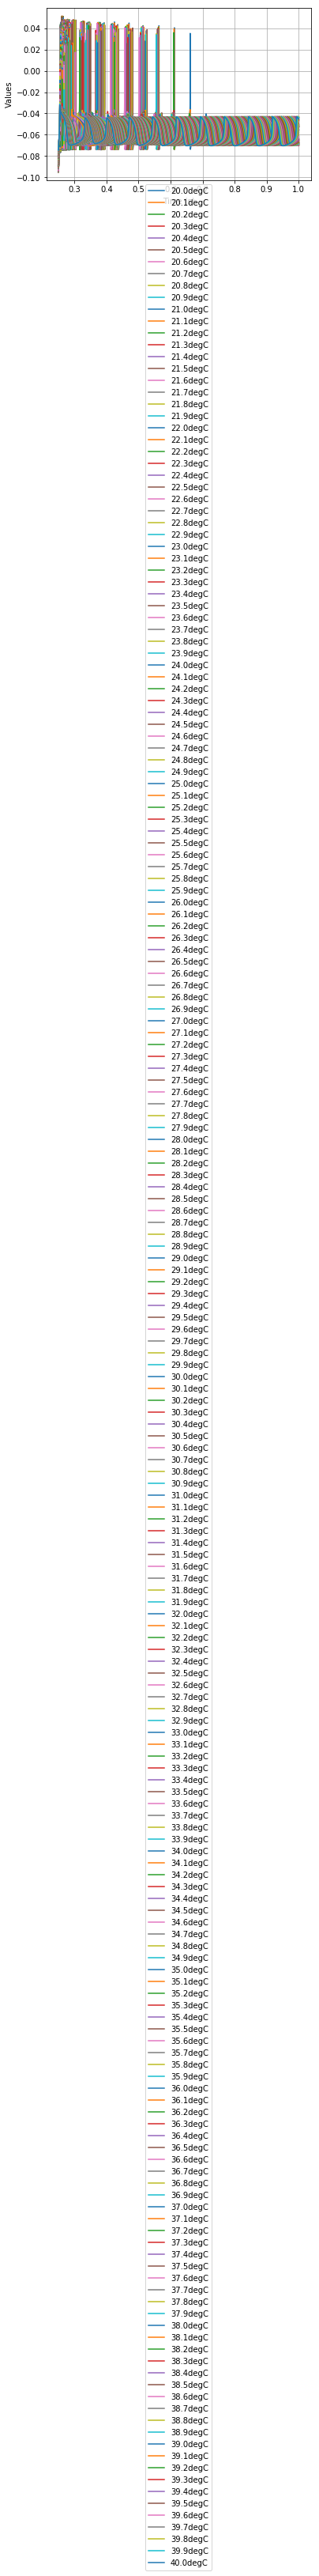

In [68]:
import matplotlib
import matplotlib.pyplot as plt

plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.grid(True)

#plt.gca().clear()

for key in output_dict:
    if key == 't':
        # no need to plot sim time against sim time
        continue
    plt.plot(output_dict['t'],output_dict[key], label=""+key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.show()